In [1]:
import dask
import dask.threaded
import dask.multiprocessing
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(n_workers=2, threads_per_worker=2,dashboard_address=':8888')

client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:44069 Dashboard: http://127.0.0.1:8888/status,Cluster Workers: 2 Cores: 4 Memory: 35.01 GB


In [2]:
## Path for modules

import sys

import numpy as np
import xarray as xr

from netCDF4 import Dataset

sys.path.insert(0,"/mnt/meom/workdir/henelle/Notebooks/git/xscale")
import xscale
import xscale.spectral.fft as xfft

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import numpy.ma as ma

import matplotlib.cm as mplcm
import matplotlib.colors as colors
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import date, datetime
from xhistogram.xarray import histogram

import pandas as pd

import seaborn as sns
sns.set(color_codes=True)

%matplotlib inline

In [3]:
def plot_histo_space(chunkx,chunky):
    
    ## Dataset

    data_dirT0 = '/mnt/meom/workdir/henelle/eNATL60/eNATL60-BLBT02-S/1h/ACO/'
    data_dir00 = '/mnt/meom/workdir/henelle/eNATL60/eNATL60-BLB002-S/1h/ACO/'

    ## All files, JAS

    # No tide
    tfilename_strain00 = data_dir00 + 'eNATL60ACO-BLB002_y2009*.1h_strain10m.nc'
    tfilename_curl00   = data_dir00 + 'eNATL60ACO-BLB002_y2009*.1h_curl10m.nc'

    # Tide
    tfilename_strainT0 = data_dirT0 + 'eNATL60ACO-BLBT02_y2009*.1h_strain10m.nc'
    tfilename_curlT0   = data_dirT0 + 'eNATL60ACO-BLBT02_y2009*.1h_curl10m.nc'

    fstrain00 = xr.open_mfdataset(tfilename_strain00,combine='by_coords',parallel=True,chunks={'x':chunkx,'y':chunky})
    strain00 = fstrain00['sostrainoverf'][:]
    navlat = fstrain00['nav_lat'][0]
    navlon = fstrain00['nav_lon'][0]

    fstrainT0 = xr.open_mfdataset(tfilename_strainT0,combine='by_coords',parallel=True,chunks={'x':chunkx,'y':chunky})
    strainT0=fstrainT0['sostrainoverf'][:]

    fcurl00 = xr.open_mfdataset(tfilename_curl00,combine='by_coords',parallel=True,chunks={'x':chunkx,'y':chunky})
    curl00=fcurl00['socurloverf'][:]

    fcurlT0   = xr.open_mfdataset(tfilename_curlT0,combine='by_coords',parallel=True,chunks={'x':chunkx,'y':chunky})
    curlT0 = fcurlT0['socurloverf'][:]

    T=2*np.pi/(1E-4) # Coriolis period

    wstrainT0 = strainT0.window
    wstrainT0.set(n=48,dim='time_counter', cutoff=2*T)
    strainT0_filt = wstrainT0.convolve()

    wstrain00 = strain00.window
    wstrain00.set(n=48,dim='time_counter', cutoff=2*T)
    strain00_filt = wstrain00.convolve()

    wcurlT0 = curlT0.window
    wcurlT0.set(n=48,dim='time_counter', cutoff=2*T)
    curlT0_filt = wcurlT0.convolve()

    wcurl00 = curl00.window
    wcurl00.set(n=48,dim='time_counter', cutoff=2*T)
    curl00_filt = wcurl00.convolve()

    box=(-31,-28,33,36)
    domain=(box[0]<navlon)*(navlon<box[1])*(box[2]<navlat)*(navlat<box[3])
    where=np.where(domain)

    jmin = where[0][0]
    jmax = where[0][-1]
    imin = where[1][0]
    imax = where[1][-1]

    strainT0_filtbox = strainT0_filt[:,jmin:jmax+1,imin:imax+1]
    strain00_filtbox = strain00_filt[:,jmin:jmax+1,imin:imax+1]
    curlT0_filtbox = curlT0_filt[:,jmin:jmax+1,imin:imax+1]
    curl00_filtbox = curl00_filt[:,jmin:jmax+1,imin:imax+1]

    sbins = np.arange(0.0,0.5, 0.025)
    cbins = np.arange(-0.5,0.5, 0.025)

    hist_JAS_strain00_filtbox = histogram(strain00_filtbox,bins=[sbins])
    hist_JAS_strainT0_filtbox = histogram(strainT0_filtbox,bins=[sbins])
    hist_JAS_curl00_filtbox   = histogram(curl00_filtbox,bins=[cbins])
    hist_JAS_curlT0_filtbox   = histogram(curlT0_filtbox,bins=[cbins])
    
    log_hist_JAS_strain00 = np.log10(hist_JAS_strain00_filtbox)
    log_hist_JAS_strainT0 = np.log10(hist_JAS_strainT0_filtbox)
    log_hist_JAS_curl00   = np.log10(hist_JAS_curl00_filtbox)
    log_hist_JAS_curlT0   = np.log10(hist_JAS_curlT0_filtbox)

    fig = plt.figure(figsize=(14,20))
    gs = gridspec.GridSpec(nrows=1, ncols=2, height_ratios=[2]) 
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
   
  
    # Adding histograms
    log_hist_JAS_strain00.plot(ax=ax1,label='no tide',lw=3.0,color='lightseagreen')
    log_hist_JAS_strainT0.plot(ax=ax1,label='tide',lw=3.0,linestyle='-.',color='darkred')
    ax1.set_xlabel('24h filtered '+'curl/f',size=16)
    ax1.set_ylabel('')
    ax1.tick_params(labelsize=15)

    log_hist_JAS_curl00.plot(ax=ax2,label='no tide',lw=3.0,color='lightseagreen')
    log_hist_JAS_curlT0.plot(ax=ax2,label='tide',lw=3.0,linestyle='-.',color='darkred')
    ax2.set_xlabel('24h filtered '+'strain/f',size=16)
    ax2.set_ylabel('')
    ax2.tick_params(labelsize=15)
    
    # Designing legend
    plt.draw()
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center',frameon=True,shadow=True,fontsize=16,bbox_to_anchor=(0.5, 0.07, 0.5, 0.5),
               markerscale=5.0,framealpha=0.8,edgecolor='black',facecolor='white')
    

    ax1.set_xlim((-0.5,0.5))
    ax2.set_xlim((0,0.5))

def plot_surf(data1,data2,vmin,vmax,var_title_data1,var_title_data2,cmap,extend):
    fig = plt.figure(figsize=(14,20))
    gs = gridspec.GridSpec(nrows=1, ncols=2, height_ratios=[2]) 
    
    
    ax1 = fig.add_subplot(gs[0, 0],projection=ccrs.PlateCarree())#221
    ax2 = fig.add_subplot(gs[0, 1],projection=ccrs.PlateCarree())#222
    
    # Adjust subplots
    plt.subplots_adjust(hspace=0.0,wspace=0.1)
    
    norm_fld_data1 = colors.Normalize(vmin=vmin, vmax=vmax, clip=False)
    
    pcolor1 = ax1.pcolormesh(lon,lat,data1,cmap=cmap,vmin=vmin,vmax=vmax,norm = norm_fld_data1)
    pcolor2 = ax2.pcolormesh(lon,lat,data2,cmap=cmap,vmin=vmin,vmax=vmax,norm = norm_fld_data1)
    
    # Add the Azores
    land = cfeature.GSHHSFeature(scale='intermediate',
                                 levels=[1],
                                 facecolor='dimgray')
    ax1.add_feature(land)
    ax2.add_feature(land)
    
    
    # Colorbar ax1
    cax1,kw1   = mpl.colorbar.make_axes(ax1,location='bottom',pad=0.05,shrink=0.95)
    out1       = fig.colorbar(pcolor1,cax=cax1,extend=extend,**kw1)
    out1.set_label(var_title_data1,size=16)
    out1.ax.tick_params(labelsize=16)
    xticks_ax1 = np.linspace(vmin,vmax,num=5)
    out1.set_ticks(xticks_ax1)
    
    # Colorbar ax2
    cax2,kw2   = mpl.colorbar.make_axes(ax2,location='bottom',pad=0.05,shrink=0.95)
    out2       = fig.colorbar(pcolor1,cax=cax2,extend=extend,**kw2)
    out2.set_label(var_title_data2,size=16)
    out2.ax.tick_params(labelsize=16)
    xticks_ax2 = np.linspace(vmin,vmax,num=5)
    out2.set_ticks(xticks_ax2)
    
    # Grid    
    gl1            = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,lw=1,color='gray',alpha=0.8, ls='--')
    gl1.xformatter = LONGITUDE_FORMATTER
    gl1.yformatter = LATITUDE_FORMATTER
    gl1.xlabel_style = {'size': 13, 'color': 'dimgray'}
    gl1.ylabel_style = {'size': 13, 'color': 'dimgray'}
    gl1.xlabels_top = False
    gl1.ylabels_right = False
    gl2            = ax2.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,lw=1,color='gray',alpha=0.8, ls='--')
    gl2.xformatter = LONGITUDE_FORMATTER
    gl2.yformatter = LATITUDE_FORMATTER
    gl2.xlabel_style = {'size': 13, 'color': 'dimgray'}
    gl2.ylabel_style = {'size': 13, 'color': 'dimgray'}
    gl2.xlabels_top = False
    gl2.ylabels_right = False
    gl2.ylabels_left = False
    
    # Adjusting axes
    ax1.set_xlim((-36, -26))
    ax1.set_ylim((25, 40))
    ax2.set_xlim((-36, -26))
    ax2.set_ylim((25, 40))

## Dataset : grid files and one example of U and V for test

dirgrid='/mnt/meom/workdir/alberta/eNATL60/eNATL60-I/'
gridfile=dirgrid+'mesh_hgr_eNATL60ACO_3.6.nc'
dsgrid=xr.open_dataset(gridfile,chunks={'x':500,'y':500})

e1u=dsgrid.e1u
e1v=dsgrid.e1v
e2u=dsgrid.e2u
e2v=dsgrid.e2v
ff=dsgrid.ff

dirvar='/mnt/meom/workdir/alberta/eNATL60/eNATL60-BLBT02-S/1h/ACO/'
ufile=dirvar+'eNATL60ACO-BLBT02_y2009m12d12.1h_sozocrtx.nc'
vfile=dirvar+'eNATL60ACO-BLBT02_y2009m12d12.1h_somecrty.nc'
dsu=xr.open_dataset(ufile,chunks={'x':500,'y':500})
dsv=xr.open_dataset(vfile,chunks={'x':500,'y':500})
u=dsu.sozocrtx[0]
v=dsv.somecrty[0]
lon=dsu.nav_lon
lat=dsu.nav_lat

def curl(u,v,e1v,e2u,ff):
    '''
    This routine computes the relative vorticity from 2D fields of horizontal velocities and the spatial Coriolis parameter.
    '''
    #Computation of dy(u)
    fe2u=1/e2u
    fse2u=fe2u.squeeze()
    dyu=(u.shift(y=-1) - u)*fse2u
    #Computation of dx(v)
    fe1v=1/e1v
    fse1v=fe1v.squeeze()
    dxv=(v.shift(x=-1) - v)*fse1v
    #Projection on the grid T
    dxvt=0.5*(dxv.shift(y=-1)+dxv)
    dyut=0.5*(dyu.shift(x=-1)+dyu)
    #Computation of the vorticity divided by f
    fff=1/ff
    curl=(dxvt-dyut)*fff
    return curl

def strain(u,v,e1u,e1v,e2u,e2v,ff):
    '''
    This routine computes the relative vorticity from 2D fields of horizontal velocities and the spatial Coriolis parameter.
    '''
    #Computation of dy(u)
    fe2u=1/e2u
    fse2u=fe2u.squeeze()
    dyu=(u.shift(y=-1) - u)*fse2u
    #Computation of dx(v)
    fe1v=1/e1v
    fse1v=fe1v.squeeze()
    dxv=(v.shift(x=-1) - v)*fse1v
    #Computation of dy(v)
    fe2v=1/e2v
    fse2v=fe2v.squeeze()
    dyv=(v.shift(y=-1) - v)*fse2v
    #Computation of dx(u)
    fe1u=1/e1u
    fse1u=fe1u.squeeze()
    dxu=(u.shift(x=-1) - u)*fse1u
    #Projection on the grid T
    dxvt=0.5*(dxv.shift(y=-1)+dxv)
    dyut=0.5*(dyu.shift(x=-1)+dyu)
    dxut=0.5*(dxu.shift(x=-1)+dxu)
    dyvt=0.5*(dyv.shift(y=-1)+dyv)
    #Computation of the strain divided by f
    fff=1/ff
    strain=np.sqrt( (dyut+dxvt)*(dyut+dxvt) + (dxut-dyvt)*(dxut-dyvt) ) *fff
    return strain

#Compute curl and strain with python

curl_python=curl(u,v,e1v,e2u,ff)
strain_python=strain(u,v,e1u,e1v,e2u,e2v,ff)

In [4]:
#plot_surf(strain_python.squeeze(),strain_python.squeeze(),0,0.5,'strain computed with python','same','YlGn',
#         'max')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.2 µs


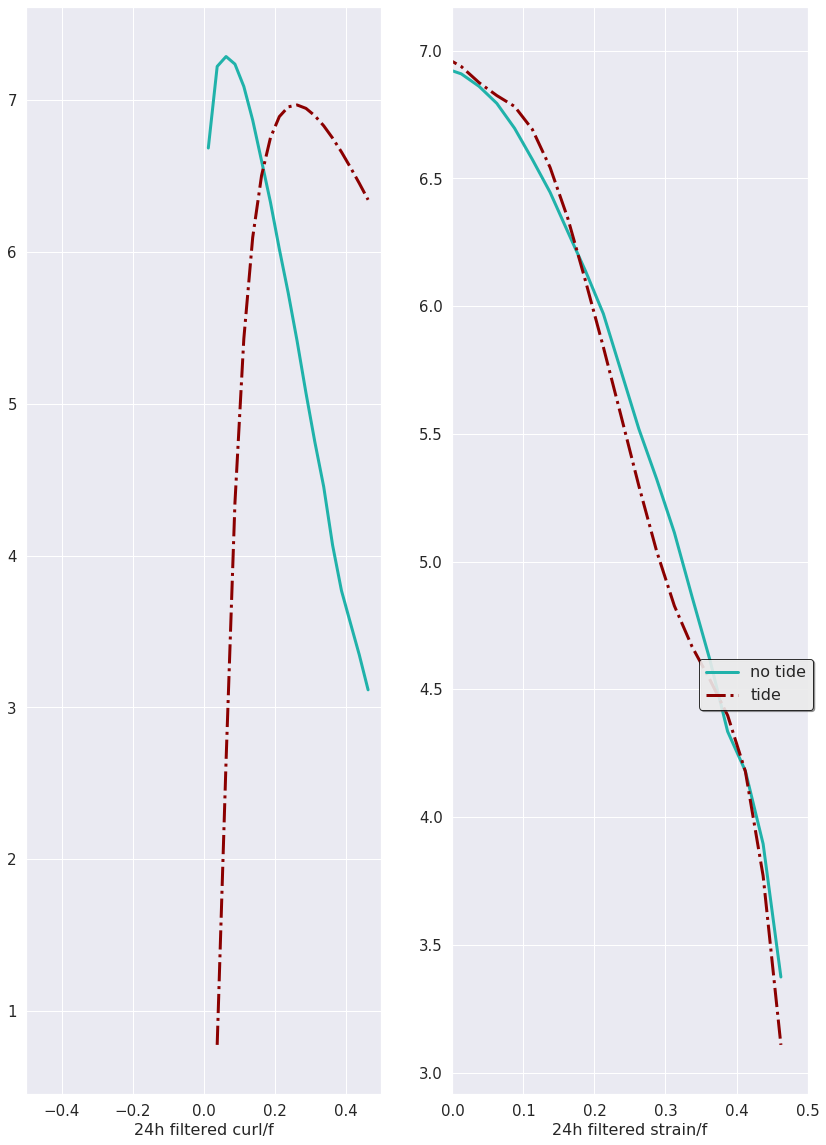

In [5]:
%time
plot_histo_space(100,100)